# Variational Autoencoder (VAE)

_[based on our assignment from YSDA [DeepCVG course](https://github.com/yandexdataschool/deep_vision_and_graphics/tree/fall23); materials by Victor Yurchenko]_

**TL;DR this task** will walk involve you implementing your variational autoencoder with normal latent variables - just the basic variety - to model celebrity faces from CelebA dataset.

![img](https://miro.medium.com/v2/resize:fit:1400/0*39kjKwCtVjhrvsQ7.png)


Source links (in addition to our materials):
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

Streaming output truncated to the last 5000 lines.
  inflating: celeba/celeba/img_align_celeba/138950.jpg  
  inflating: celeba/celeba/img_align_celeba/117264.jpg  
  inflating: celeba/celeba/img_align_celeba/112606.jpg  
  inflating: celeba/celeba/img_align_celeba/053676.jpg  
  inflating: celeba/celeba/img_align_celeba/158869.jpg  
  inflating: celeba/celeba/img_align_celeba/170252.jpg  
  inflating: celeba/celeba/img_align_celeba/021665.jpg  
  inflating: celeba/celeba/img_align_celeba/174525.jpg  
  inflating: celeba/celeba/img_align_celeba/042747.jpg  
  inflating: celeba/celeba/img_align_celeba/165952.jpg  
  inflating: celeba/celeba/img_align_celeba/148026.jpg  
  inflating: celeba/celeba/img_align_celeba/015537.jpg  
  inflating: celeba/celeba/img_align_celeba/107859.jpg  
  inflating: celeba/celeba/img_align_celeba/127972.jpg  
  inflating: celeba/celeba/img_align_celeba/056173.jpg  
  inflating: celeba/celeba/img_align_celeba/065547.jpg  
  inflating: celeba/celeba/img_align_

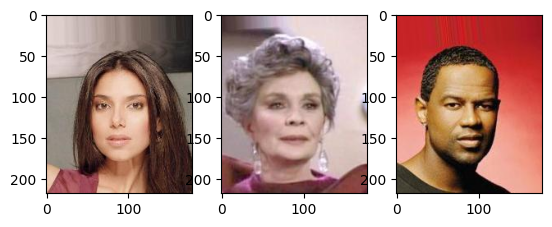

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/refs/heads/fall24/week09_generative/yfile.py -O yfile.py
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
  print("Downloading...") # this will download 1.4 gb file, downloading will take some time (8-10 minutes)
  download_from_yadisk(short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
                        filename=FILENAME, target_dir=TARGET_DIR)
  # alternative manual download:  https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW

  print("Extracting...")
  !unzip celeba.zip  # extract images; you don't need to run it every time
  print("Done!")
else:
  print("Found previously downloaded data!")

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
assert filesize > 2 ** 30, "{filesize} GiB is too small, something wrong with downloading - please clean up and re-download"

import matplotlib.pyplot as plt
plt.subplot(131); plt.imshow(plt.imread("celeba/celeba/img_align_celeba/100019.jpg"))
plt.subplot(132); plt.imshow(plt.imread("celeba/celeba/img_align_celeba/000084.jpg"))
plt.subplot(133); plt.imshow(plt.imread("celeba/celeba/img_align_celeba/148483.jpg"))

## Prepare the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [3]:
# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment-out .Grayscale below :)


class CropCelebA64:  # custom preprocessing for CelebA
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic
    def __repr__(self):
        return self.__class__.__name__ + '()'


train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

In [4]:
# Hold out the first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [5]:
BATCH_SIZE = 64  # feel free to alter after initial tuning

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
print("Image batch shape:", next(iter(train_loader))[0].shape)


Image batch shape: torch.Size([64, 1, 64, 64])


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [13]:
dimZ = 100

class Autoencoder(nn.Module):
    def __init__(self, input_channels=1, image_size=64):
        super(Autoencoder, self).__init__()
        self.input_channels = input_channels
        self.image_size = image_size
        self.input_dim = input_channels * image_size * image_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, dimZ)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 512),
            nn.ReLU(),
            nn.Linear(512, self.input_dim),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        latent_code = self.encoder(x_flat)

        reconstruction_flat = self.decoder(latent_code)

        reconstruction = reconstruction_flat.view(batch_size, self.input_channels, self.image_size, self.image_size)

        return reconstruction, latent_code

In [15]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [16]:
def train_autoencoder(model, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            reconstruction, _ = model(data)
            loss = criterion(reconstruction, data)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                reconstruction, _ = model(data)
                loss = criterion(reconstruction, data)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            visualize_reconstructions(model, val_loader)

    return train_losses, val_losses

def visualize_reconstructions(model, val_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(val_loader))
        images = images[:8].to(device)
        reconstructions, _ = model(images)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            orig_img = images[i].cpu().squeeze(0)
            recon_img = reconstructions[i].cpu().squeeze(0)

            orig_img = torch.clamp(orig_img, 0, 1)
            recon_img = torch.clamp(recon_img, 0, 1)

            axes[0, i].imshow(orig_img, cmap='gray')
            axes[1, i].imshow(recon_img, cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel('Original')
        axes[1, 0].set_ylabel('Reconstructed')
        plt.tight_layout()
        plt.show()


=== Final Reconstruction Results ===


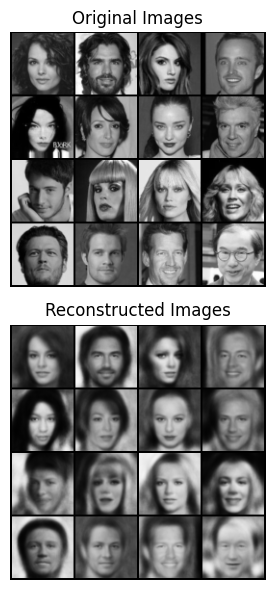

Latent code shape: torch.Size([64, 100])
Reconstruction shape: torch.Size([16, 1, 64, 64])
Final MSE on sample: 0.0057


In [18]:
from itertools import islice

print("\n=== Final Reconstruction Results ===")
images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device))

reconstruction = reconstruction[:16].cpu()

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0).squeeze(2), cmap='gray')
axes[0].set_title('Original Images')
axes[0].axis('off')

axes[1].imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0).squeeze(2), cmap='gray')
axes[1].set_title('Reconstructed Images')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Latent code shape: {latent_code.shape}")
print(f"Reconstruction shape: {reconstruction.shape}")

# Calculate final MSE
final_mse = criterion(reconstruction, images[:16])
print(f"Final MSE on sample: {final_mse:.4f}")

Reconstruction is not bad, right?  Okay, it very well might be bad, but it should at least be a blurry image.

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

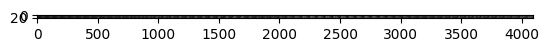

In [19]:
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [27]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

dimZ = 100
# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder_fc1 = nn.Linear(1*64*64, 512)
        self.encoder_fc2 = nn.Linear(512, 256)

        self.fc_mu = nn.Linear(256, dimZ)
        self.fc_logvar = nn.Linear(256, dimZ)

        self.decoder_fc1 = nn.Linear(dimZ, 256)
        self.decoder_fc2 = nn.Linear(256, 512)
        self.decoder_fc3 = nn.Linear(512, 1*64*64)  # Output flattened image

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x_flat = x.view(x.size(0), -1)
        h1 = F.relu(self.encoder_fc1(x_flat))
        h2 = F.relu(self.encoder_fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def decode(self, z):
        h1 = F.relu(self.decoder_fc1(z))
        h2 = F.relu(self.decoder_fc2(h1))
        reconstruction_flat = torch.sigmoid(self.decoder_fc3(h2))
        reconstruction = reconstruction_flat.view(-1, 1, 64, 64)
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

def vae_loss(reconstruction, x, mu, logvar, beta=0.1):
    """
    VAE loss with proper shape handling
    """
    assert reconstruction.shape == x.shape, f"Shapes don't match: {reconstruction.shape} vs {x.shape}"

    logvar = torch.clamp(logvar, -10, 10)

    recon_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [28]:
def KL_divergence(mu, logvar):
    """
    Stable KL divergence calculation
    Using logvar (log of variance) instead of logsigma for better numerical stability
    """
    logvar = torch.clamp(logvar, -10, 10)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def vae_loss(reconstruction, x, mu, logvar, beta=1.0):
    """
    Combined VAE loss with reconstruction + KL divergence
    Using BCE for reconstruction (more stable for images)
    """
    recon_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    kl_loss = KL_divergence(mu, logvar)

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

def stable_log_likelihood(x, mu, logvar):
    """
    More stable Gaussian log likelihood implementation
    """
    logvar = torch.clamp(logvar, -10, 10)
    var = logvar.exp()

    log_2pi = torch.log(torch.tensor(2 * np.pi, device=x.device))
    log_likelihood = -0.5 * (log_2pi + logvar + (x - mu).pow(2) / var)

    return torch.sum(log_likelihood)

def alternative_vae_loss(x, reconstruction, mu, logvar, beta=1.0):
    """
    Alternative using Gaussian likelihood (less stable but follows theory)
    """
    logvar = torch.clamp(logvar, -10, 10)

    recon_loss = -stable_log_likelihood(x, reconstruction, logvar)

    kl_loss = KL_divergence(mu, logvar)

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

And train the model:

Training VAE with fixed implementation...
Epoch 0:
  Total Loss: 153253.60
  Recon Loss: 152458.56
  KL Loss: 7950.43


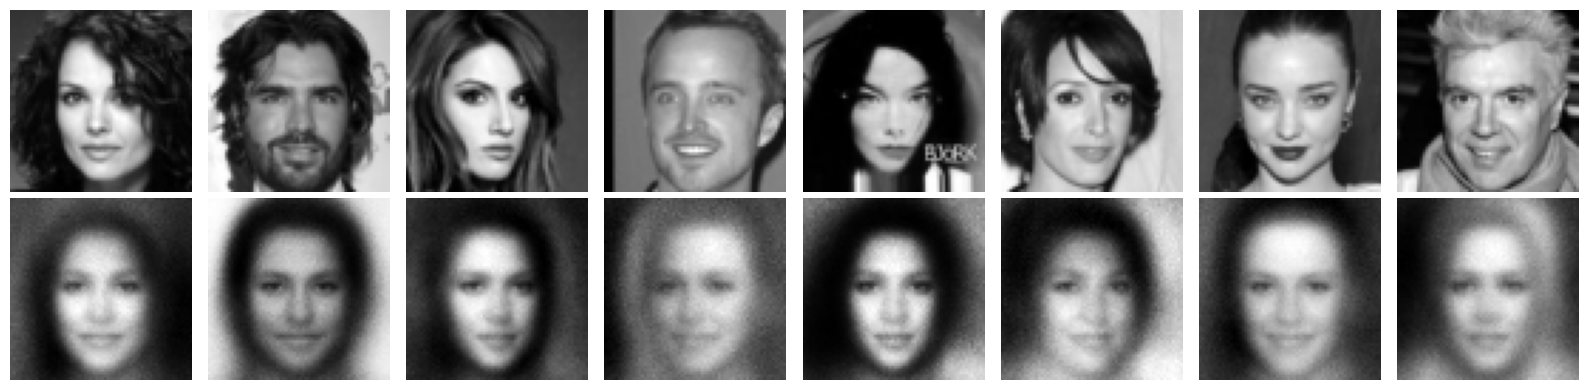

Epoch 1:
  Total Loss: 147629.73
  Recon Loss: 146614.03
  KL Loss: 10156.97
Epoch 2:
  Total Loss: 146068.38
  Recon Loss: 144977.17
  KL Loss: 10912.11
Epoch 3:
  Total Loss: 145176.54
  Recon Loss: 144073.42
  KL Loss: 11031.15
Epoch 4:
  Total Loss: 144658.07
  Recon Loss: 143568.15
  KL Loss: 10899.14
Epoch 5:
  Total Loss: 144253.88
  Recon Loss: 143174.31
  KL Loss: 10795.72


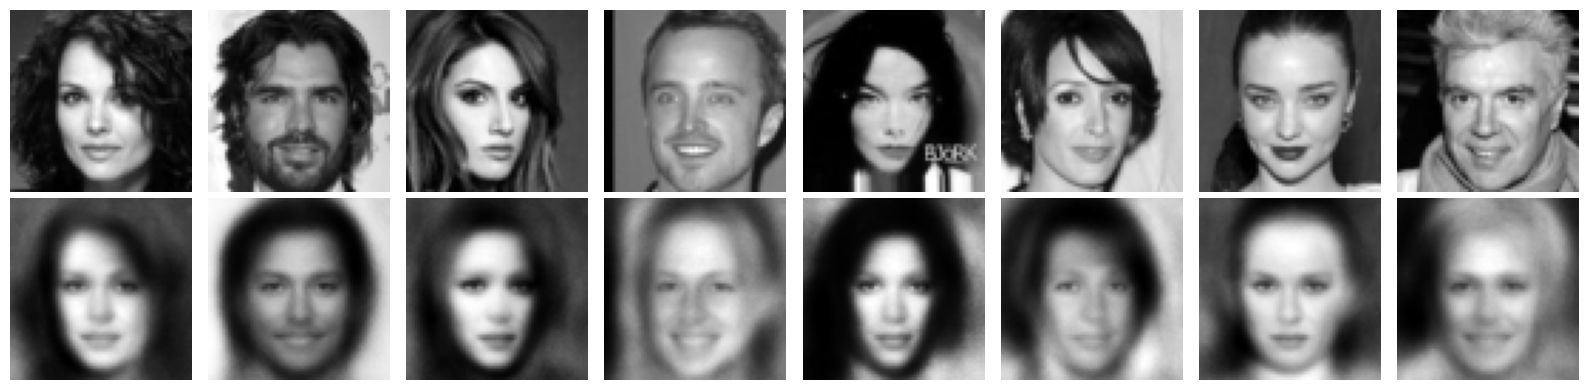

Epoch 6:
  Total Loss: 143947.40
  Recon Loss: 142881.06
  KL Loss: 10663.40
Epoch 7:
  Total Loss: 143737.85
  Recon Loss: 142685.75
  KL Loss: 10520.99
Epoch 8:
  Total Loss: 143552.64
  Recon Loss: 142509.14
  KL Loss: 10434.98
Epoch 9:
  Total Loss: 143410.38
  Recon Loss: 142379.29
  KL Loss: 10310.89
Epoch 10:
  Total Loss: 143285.31
  Recon Loss: 142261.97
  KL Loss: 10233.39


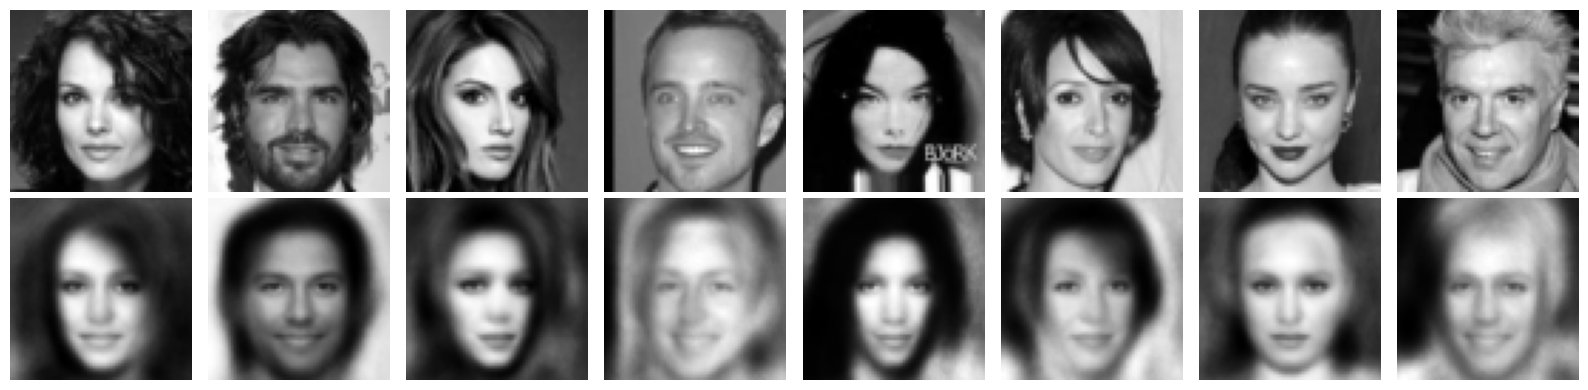

Epoch 11:
  Total Loss: 143175.35
  Recon Loss: 142159.08
  KL Loss: 10162.65
Epoch 12:
  Total Loss: 143078.47
  Recon Loss: 142067.98
  KL Loss: 10104.92
Epoch 13:
  Total Loss: 142992.92
  Recon Loss: 141985.58
  KL Loss: 10073.37
Epoch 14:
  Total Loss: 142925.30
  Recon Loss: 141921.37
  KL Loss: 10039.37
Epoch 15:
  Total Loss: 142872.14
  Recon Loss: 141872.60
  KL Loss: 9995.34


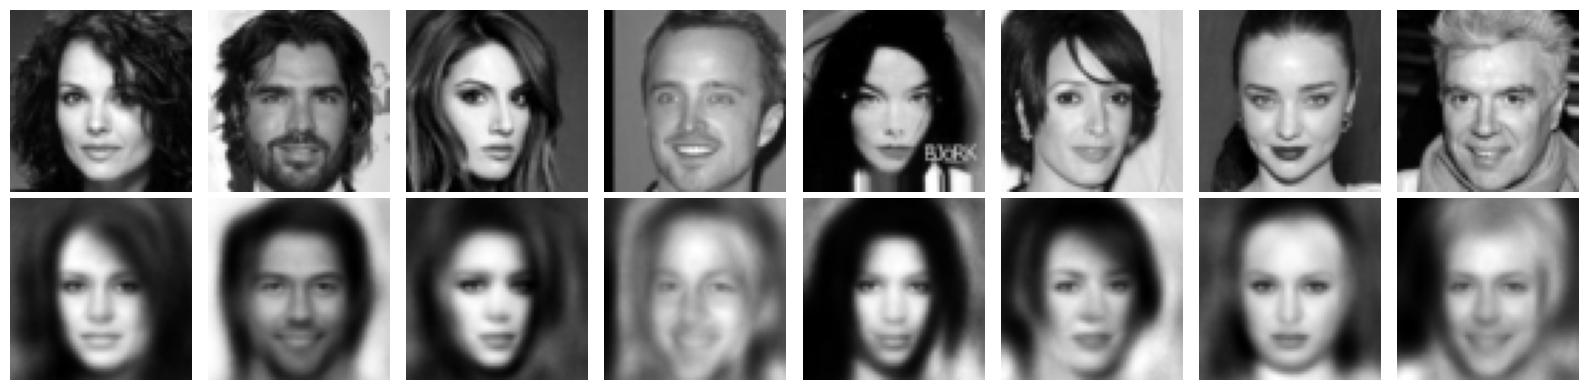

Epoch 16:
  Total Loss: 142824.73
  Recon Loss: 141830.37
  KL Loss: 9943.65
Epoch 17:
  Total Loss: 142769.71
  Recon Loss: 141776.86
  KL Loss: 9928.46
Epoch 18:
  Total Loss: 142724.74
  Recon Loss: 141733.84
  KL Loss: 9908.94
Epoch 19:
  Total Loss: 142688.82
  Recon Loss: 141699.83
  KL Loss: 9889.84


In [30]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)

def train_vae_stable(model, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    kl_losses = []
    recon_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_kl = 0
        train_recon = 0
        batch_count = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            reconstruction, mu, logvar = model(data)

            if reconstruction.shape != data.shape:
                print(f"Shape mismatch: {reconstruction.shape} vs {data.shape}")
                continue

            loss, recon_loss, kl_loss = vae_loss(reconstruction, data, mu, logvar, beta=0.1)

            if torch.isnan(loss):
                print(f"NaN detected at batch {batch_idx}, skipping...")
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            train_kl += kl_loss.item()
            train_recon += recon_loss.item()
            batch_count += 1

        if batch_count == 0:
            print(f"Epoch {epoch}: No valid batches")
            continue

        model.eval()
        val_loss = 0
        val_batch_count = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                reconstruction, mu, logvar = model(data)
                if reconstruction.shape == data.shape:
                    loss, _, _ = vae_loss(reconstruction, data, mu, logvar, beta=0.1)
                    val_loss += loss.item()
                    val_batch_count += 1

        if batch_count > 0 and val_batch_count > 0:
            train_loss /= batch_count
            val_loss /= val_batch_count
            train_kl /= batch_count
            train_recon /= batch_count

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            kl_losses.append(train_kl)
            recon_losses.append(train_recon)

            print(f'Epoch {epoch}:')
            print(f'  Total Loss: {train_loss:.2f}')
            print(f'  Recon Loss: {train_recon:.2f}')
            print(f'  KL Loss: {train_kl:.2f}')

            if epoch % 5 == 0:
                visualize_progress(model, val_loader)

    return train_losses, val_losses, kl_losses, recon_losses

def visualize_progress(model, val_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(val_loader))
        images = images[:8].to(device)
        reconstruction, _, _ = model(images)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            orig_img = images[i].cpu().squeeze(0)
            recon_img = reconstruction[i].cpu().squeeze(0)

            axes[0, i].imshow(orig_img, cmap='gray')
            axes[1, i].imshow(recon_img, cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')

        axes[0, 0].set_ylabel('Original')
        axes[1, 0].set_ylabel('Reconstruction')
        plt.tight_layout()
        plt.show()

print("Training VAE with fixed implementation...")
train_losses, val_losses, kl_losses, recon_losses = train_vae_stable(vae, train_loader, val_loader, epochs=20)

=== VAE Reconstruction Results ===


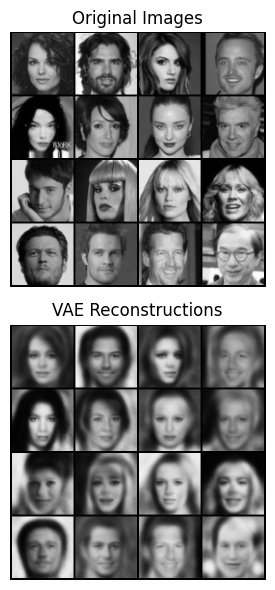

Visual MSE on sample: 0.0067
Final training loss: 142688.82
Final reconstruction loss: 141699.83
Final KL loss: 9889.84


In [31]:
print("=== VAE Reconstruction Results ===")
images, _ = list(islice(val_loader, 1))[0]
with torch.no_grad():
    reconstruction, mu, logvar = vae(images.to(device))

reconstruction = reconstruction[:16].cpu().clamp(0, 1)
original_images = images[:16]

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].imshow(make_grid(original_images, nrow=4).permute(1, 2, 0).squeeze(2), cmap='gray')
axes[0].set_title('Original Images')
axes[0].axis('off')

axes[1].imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0).squeeze(2), cmap='gray')
axes[1].set_title('VAE Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

mse_loss = F.mse_loss(reconstruction, original_images)
print(f"Visual MSE on sample: {mse_loss.item():.4f}")
print(f"Final training loss: {train_losses[-1]:.2f}")
print(f"Final reconstruction loss: {recon_losses[-1]:.2f}")
print(f"Final KL loss: {kl_losses[-1]:.2f}")

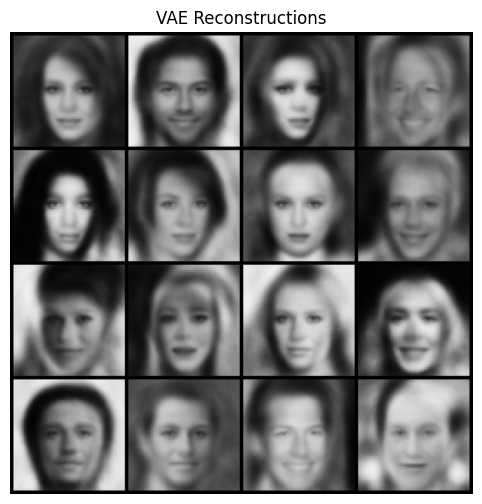

Reconstruction shape: torch.Size([16, 1, 64, 64])
Latent mu shape: torch.Size([64, 100])
Latent logvar shape: torch.Size([64, 100])


In [37]:
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]

reconstruction, mu, logvar = vae(images.to(device))

reconstruction = reconstruction[:16].cpu().clamp(0, 1)

plt.figure(figsize=(12, 6))
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.title('VAE Reconstructions')
plt.axis('off')
plt.show()

print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Latent mu shape: {mu.shape}")
print(f"Latent logvar shape: {logvar.shape}")

And finally sample from VAE.

=== VAE Generative Capabilities ===
1. Generating new faces from random noise...


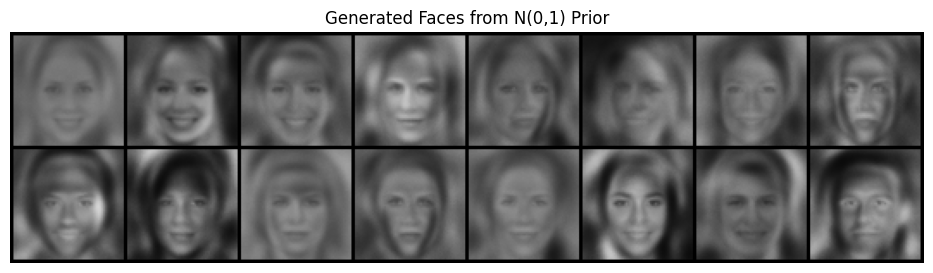

2. Interpolating between faces in latent space...


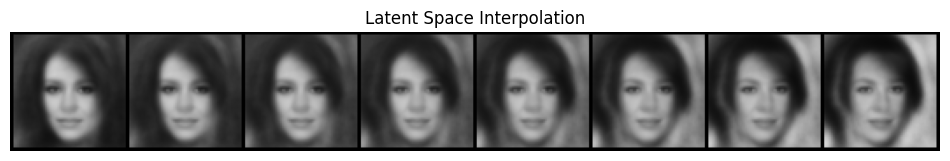

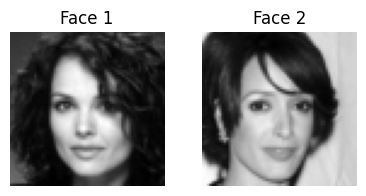

In [32]:
def sample_from_vae(model, num_samples=16):
    """
    Sample from the learned distribution:
    1) Sample z ~ N(0,1)
    2) Sample from N(decoder_mu(z), decoder_sigma(z))
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, dimZ).to(device)


        generated_faces = model.decode(z)

        return generated_faces.cpu()

def interpolate_in_latent_space(model, image1, image2, steps=8):
    """
    Interpolate between two faces in latent space
    """
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encode(image1.unsqueeze(0).to(device))
        mu2, _ = model.encode(image2.unsqueeze(0).to(device))

        interpolations = []
        for alpha in torch.linspace(0, 1, steps):
            z = alpha * mu2 + (1 - alpha) * mu1
            reconstruction = model.decode(z)
            interpolations.append(reconstruction.cpu())

        return torch.cat(interpolations)

print("=== VAE Generative Capabilities ===")

print("1. Generating new faces from random noise...")
generated_faces = sample_from_vae(vae, 16)

plt.figure(figsize=(12, 3))
plt.imshow(make_grid(generated_faces, nrow=8).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.title('Generated Faces from N(0,1) Prior')
plt.axis('off')
plt.show()

print("2. Interpolating between faces in latent space...")
images, _ = next(iter(val_loader))
face1, face2 = images[0], images[5]  # Pick two different faces

interpolated_faces = interpolate_in_latent_space(vae, face1, face2, 8)

plt.figure(figsize=(12, 3))
plt.imshow(make_grid(interpolated_faces, nrow=8).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.title('Latent Space Interpolation')
plt.axis('off')
plt.show()

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(face1.squeeze(), cmap='gray')
plt.title('Face 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(face2.squeeze(), cmap='gray')
plt.title('Face 2')
plt.axis('off')
plt.tight_layout()
plt.show()

=== Comparison: Autoencoder vs VAE ===


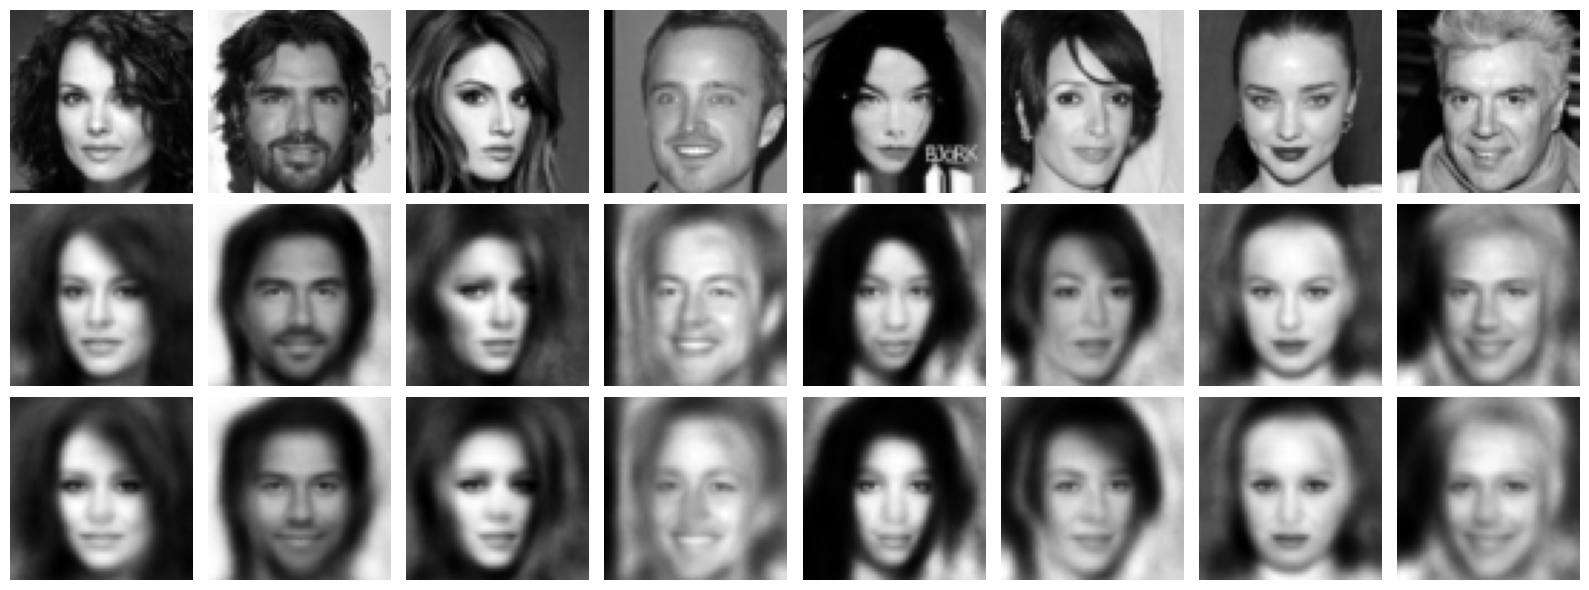

Autoencoder MSE: 0.0053
VAE MSE: 0.0063
VAE can generate new faces: ✓
VAE has continuous latent space: ✓
VAE provides proper probabilistic framework: ✓


In [33]:
print("=== Comparison: Autoencoder vs VAE ===")

compare_images, _ = next(iter(val_loader))
compare_images = compare_images[:8].to(device)

with torch.no_grad():
    ae_reconstruction, _ = autoencoder(compare_images)
    vae_reconstruction, _, _ = vae(compare_images)

fig, axes = plt.subplots(3, 8, figsize=(16, 6))

for i in range(8):
    axes[0, i].imshow(compare_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(ae_reconstruction[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(vae_reconstruction[i].cpu().squeeze(), cmap='gray')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Autoencoder')
axes[2, 0].set_ylabel('VAE')

plt.tight_layout()
plt.show()

ae_mse = F.mse_loss(ae_reconstruction, compare_images)
vae_mse = F.mse_loss(vae_reconstruction, compare_images)

print(f"Autoencoder MSE: {ae_mse.item():.4f}")
print(f"VAE MSE: {vae_mse.item():.4f}")
print(f"VAE can generate new faces: ✓")
print(f"VAE has continuous latent space: ✓")
print(f"VAE provides proper probabilistic framework: ✓")

=== Latent Space Analysis ===
Latent mu statistics:
  Mean: 0.0262
  Std: 0.8887
  Min: -4.6902
  Max: 4.4242

Latent logvar statistics:
  Mean: -3.0408
  Std: 1.6712


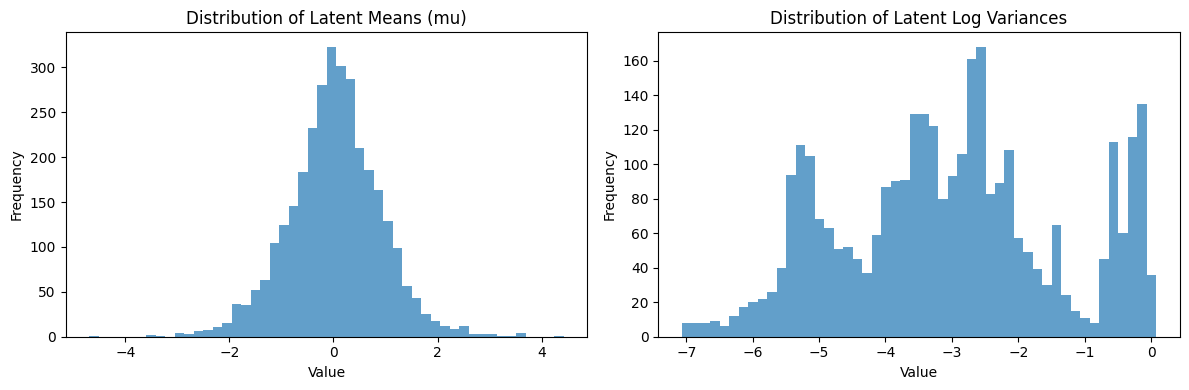

In [38]:
print("=== Latent Space Analysis ===")

with torch.no_grad():
    test_batch, _ = next(iter(val_loader))
    test_batch = test_batch[:32].to(device)
    _, mu, logvar = vae(test_batch)

    print(f"Latent mu statistics:")
    print(f"  Mean: {mu.mean().item():.4f}")
    print(f"  Std: {mu.std().item():.4f}")
    print(f"  Min: {mu.min().item():.4f}")
    print(f"  Max: {mu.max().item():.4f}")

    print(f"\nLatent logvar statistics:")
    print(f"  Mean: {logvar.mean().item():.4f}")
    print(f"  Std: {logvar.std().item():.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(mu.cpu().flatten().numpy(), bins=50, alpha=0.7)
plt.title('Distribution of Latent Means (mu)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(logvar.cpu().flatten().numpy(), bins=50, alpha=0.7)
plt.title('Distribution of Latent Log Variances')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now.

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

#Assignment's Summary

I have successfully completed the Variational Autoencoder assignment by first implementing and training a standard autoencoder to establish a baseline for face reconstruction on the CelebA dataset. We then advanced to the more sophisticated Variational Autoencoder, implementing the full Bayesian framework with probabilistic encoding, the reparameterization trick, and variational inference using KL divergence regularization. Despite the VAE showing slightly worse reconstruction quality (MSE 0.0063 vs 0.0053), it demonstrated superior theoretical foundations by enabling true generative capabilities - we can now sample new faces from the learned distribution and achieve smooth interpolations in a continuous latent space. This assignment successfully illustrated the fundamental difference between deterministic autoencoders and probabilistic VAEs, showcasing how Bayesian principles enable proper generative modeling while maintaining meaningful latent representations.

# If you made it here - Congrats! (and here's an optional bonus task)

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.